# Bandit on Linear Graphs

In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import pickle as pkl
from networkx.generators.random_graphs import path_graph


from reward import GaussianReward
from agent import LocalThompsonSamplingAgent,LocalUCBAgent, LocalRandomWalkAgent,Agent,MultiStepLookAheadAgent
from estimator import NormalBayesianEstimator
%load_ext autoreload
%autoreload 2

In [2]:
# Main Loop
def main(G,agent,T=1000):
    s_0 = np.random.choice(G.nodes)
    s = s_0

    s_hist = []
    r_hist = []

    for t in range(T):
        r = G.nodes[s]['reward_sampler'].sample()
        agent.update(s,r)

        r_hist.append(r)
        s_hist.append(s)

        s = agent.next_s()
    return s_hist, r_hist

In [3]:
from time import time
from functools import partial

In [4]:

n_trials = 50
T=10000 # Time steps allowed for one agent in each trial
lookaheads = [3,5,10]
merits = ['TS','UCB']
# lookaheads = [1]

N_nodes = 50
p_edge_form = 0.7
k_neighbors=2

agents = {'TS':partial(LocalThompsonSamplingAgent,m=50,epsilon=0.01),
         'UCB':partial(LocalUCBAgent,beta=0.5,m=50,epsilon=0.01),
         'RandomExplore':  LocalRandomWalkAgent
         }

agents.update({\
    '{}StepLookAhead{}'.format(n,mer): \
            partial(MultiStepLookAheadAgent, T = n,m = 50,epsilon = 0.01,merit = mer)\
               for n in lookaheads for mer in merits})

data = {'mu':[],'G':[]}
data.update({name:[] for name in agents.keys()})

# The format of data dictionary###
# data={'mu':[mu for each trial,'G':[G for each trial],'agent1':[s history of agent 1 for each trial],'agent2':[...],...}
#####

t = time()
for n in range(n_trials):
    # Initialize the random graph for this trial
    G = path_graph(N_nodes)
    G_no_sampler = G.copy()

    # Initialize reward sampler for each node.
    # mus = np.linspace(0,2,N_nodes)
    # sigs = np.ones(N_nodes)*0.5

    mus = np.zeros(N_nodes)
    mus[-1]=5
    mus[1]=1
    sigs = np.ones(N_nodes)*0.5
    for n in G.nodes:
        G.nodes[n]['reward_sampler'] = GaussianReward(mus[n],sigs[n])
        
    data['mu'].append(mus)
    data['G'].append(G)
    for name,agent_gen in agents.items():
        
        # agent_gen(G) creates an instance of the agent with name=name.
        s,_ = main(G,agent_gen(G_no_sampler),T)
        data[name].append(s)
print('Time elapsed:',time()-t)

Time elapsed: 847.5322425365448


In [5]:
with open('LinearRepetive.pkl','wb+') as file:
    pkl.dump(data,file)

In [6]:
data.keys()

dict_keys(['mu', 'G', 'TS', 'UCB', 'RandomExplore', '3StepLookAheadTS', '3StepLookAheadUCB', '5StepLookAheadTS', '5StepLookAheadUCB', '10StepLookAheadTS', '10StepLookAheadUCB'])

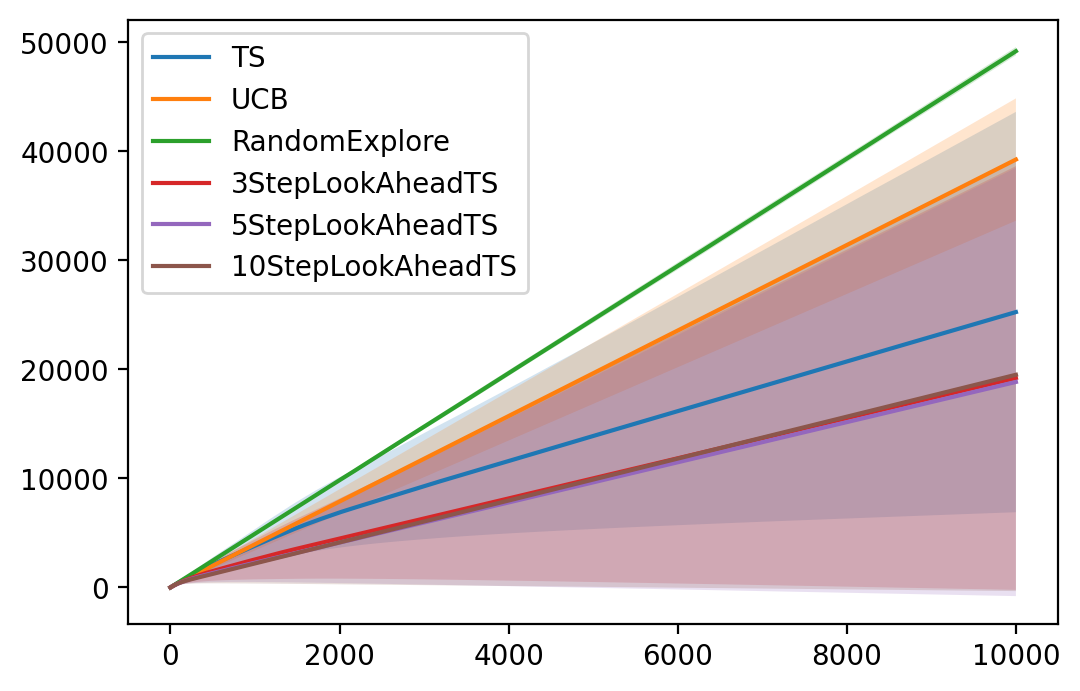

In [9]:
mus = np.array(data['mu'])
r_stars = np.max(mus,axis=1)
plt.figure(dpi=200)
for agent_name in agents.keys():
    if agent_name in ['TS', 'UCB', 'RandomExplore',\
#                       '3StepLookAheadTS', '3StepLookAheadUCB'\
#                       , '5StepLookAheadTS', '5StepLookAheadUCB'\
#                       , '10StepLookAheadTS', '10StepLookAheadUCB'\
                      '3StepLookAheadTS', '5StepLookAheadTS', '10StepLookAheadTS'\
#                       '3StepLookAheadUCB', '5StepLookAheadUCB', '10StepLookAheadUCB'\
                     ]:
#     if agent_name in ['TS', 'UCB', 'RandomExplore', '1StepLookAhead','3StepLookAhead']:
        steps = r_stars.reshape(-1,1)-mus[np.arange(n_trials).reshape(-1,1),np.array(data[agent_name])]

        regrets = np.cumsum(steps,axis = 1)

        mean_regrets = np.mean(regrets,axis= 0)
        std_regrets  = np.std(regrets,axis= 0)

        plt.plot(mean_regrets,label = agent_name)
        plt.fill_between(np.arange(T),mean_regrets-std_regrets,mean_regrets+std_regrets,alpha=0.2)
plt.legend()
plt.show()

In [15]:


r_star = np.max(mus)
s_star = np.argmax(mus)

steps = r_star-mus[np.array(s_look)]
look_regret = np.cumsum(steps)

steps = r_star-mus[np.array(s_TS)]
TS_regret = np.cumsum(steps)

steps = r_star-mus[np.array(s_UCB)]
UCB_regret = np.cumsum(steps)


steps = r_star-mus[np.array(s_control)]
control_regret = np.cumsum(steps)


plt.plot(TS_regret,label='TS')
plt.plot(UCB_regret,label='UCB')
plt.plot(look_regret,label='{}StepLookAhead')

plt.plot(control_regret,label='RandomExplore')
plt.legend()

plt.show()

labels = {n:n for n in G.nodes}
nx.draw(G,labels=labels)
plt.show()

True reward parameters:
0 0.9916331937670346
1 0.7431230610429304
2 0.9946904901148105
3 0.6958706323295496
4 0.2345916062187905
5 0.42958451943432774
6 0.5558084865146647
7 0.642392640299884
8 0.7544439698947005
9 0.2273624312674959
